In [1]:
%load_ext autoreload
%autoreload 2

import os
import numpy as np
import pandas as pd 
import sys
import pickle
import itertools
import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import random
from sklearn.metrics import pairwise_distances
from sklearn.kernel_ridge import KernelRidge
import math
import os 

workingdirectory = os.popen('git rev-parse --show-toplevel').read()[:-1]
sys.path.append(workingdirectory)
os.chdir(workingdirectory)

import allensdk.core.json_utilities as ju
from allensdk.core.mouse_connectivity_cache import MouseConnectivityCache

from mcmodels.core import VoxelModelCache, Mask
from mcmodels.core.utils import get_structure_id,get_ordered_summary_structures
from mcmodels.core.connectivity_data import get_connectivity_data
from mcmodels.utils import nonzero_unique, truncate_colormap
from mcmodels.models.crossvalidation import get_best_hyperparameters,get_loss_best_hyp,get_loss#get_loocv_predictions,get_loss#get_best_hyperparameters,get_loss_best_hyp,get_loocv_predictions,get_loss
from mcmodels.core.utils import get_indices_2ormore, get_leaves_ontologicalorder, get_indices, get_indices2,get_eval_indices,screen_index_matrices,screen_index_matrices2,screen_index_matrices3#get_cre_status,get_minorstructure_dictionary,get_leaves_ontologicalorder
from mcmodels.regressors import NadarayaWatson

/Users/samsonkoelle/miniconda3/envs/mcm_class/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.decomposition.cdnmf_fast module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.decomposition. Anything that cannot be imported from sklearn.decomposition is now part of the private API.
  warnings.warn(message, FutureWarning)
/Users/samsonkoelle/mouse_connectivity_models/mcmodels/utils.py:27: MatplotlibDeprecationWarning: Support for setting the 'text.latex.preamble' or 'pgf.preamble' rcParam to a list of strings is deprecated since 3.3 and will be removed two minor releases later; set it to a single string instead.
  mpl.rcParams["text.latex.preamble"] = [r"\usepackage{amsmath}"]
/Users/samsonkoelle/miniconda3/envs/mcm_class/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.linear_model.base module is  deprecated in 

In [2]:
#read data
TOP_DIR = workingdirectory
INPUT_JSON = workingdirectory + '/data/meta/input_011520.json'
EXPERIMENTS_EXCLUDE_JSON = workingdirectory + '/data/meta/experiments_exclude.json'
input_data = ju.read(INPUT_JSON)
experiments_exclude = ju.read(EXPERIMENTS_EXCLUDE_JSON)
manifest_file = input_data.get('manifest_file')
manifest_file = os.path.join(TOP_DIR, manifest_file)
cache = VoxelModelCache(manifest_file=manifest_file)
st = cache.get_structure_tree()
ai_map = st.get_id_acronym_map()
ia_map = {value: key for key, value in ai_map.items()}
major_structures = np.load(workingdirectory + '/data/meta/major_structures.npy')
major_structure_ids = np.load(workingdirectory + '/data/meta/major_structure_ids.npy')
data_info = pd.read_excel(workingdirectory + '/data/meta/Whole Brain Cre Image Series_curation only.xlsx', 'all datasets curated_070919pull')
data_info.set_index("id", inplace=True)
with open('data/meta/leafs.pickle', 'rb') as handle:
    leafs = pickle.load(handle)
ontological_order_leaves = np.load(workingdirectory + '/data/meta/ontological_order_leaves_v3.npy')
COARSE_STRUCTURE_SET_ID = 2
DEFAULT_STRUCTURE_SET_IDS = tuple([COARSE_STRUCTURE_SET_ID])
tree = cache.get_structure_tree()
default_structures = tree.get_structures_by_set_id(DEFAULT_STRUCTURE_SET_IDS)
default_structure_ids = [st['id'] for st in default_structures if st['id'] != 934]
folder =  '/Users/samsonkoelle/mouse_connectivity_models/data/raw/'

annotation/ccf_2017


In [3]:
connectivity_data = get_connectivity_data(cache, major_structure_ids, experiments_exclude, remove_injection = False, folder = folder)

512
703
1089
1097
315
313
354
698
771
803
477
549


In [4]:
connectivity_data.get_injection_hemisphere_ids()
connectivity_data.align()
connectivity_data.get_centroids()
connectivity_data.get_data_matrices(default_structure_ids)
connectivity_data.get_crelines(data_info)

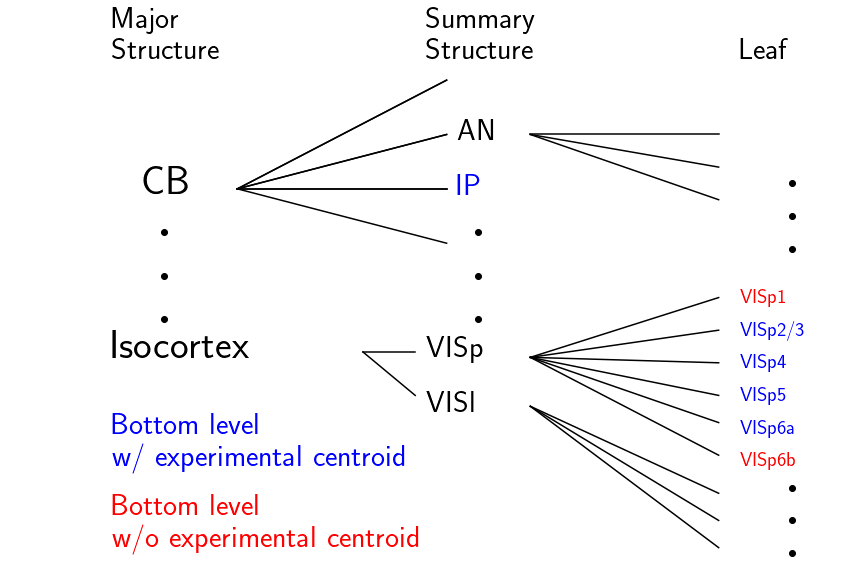

In [5]:
fig, ax = plt.subplots(figsize=(15, 10))

xs = np.asarray([0.15,0.15,0.15])
ys = np.asarray([.47,.55,.63])
xssum = np.asarray([0.45,0.45,0.45])
xsleaf = np.asarray([0.75,0.75,0.75])
ysleafbottom = np.asarray([.04,.1,.16])
ysleafmiddle = np.asarray([.6,.66,.72])
#ax = plt.Subplot(fig, outer[i])
#outer[i]
ax.scatter(xs, ys, c = 'black')
ax.scatter(xssum, ys, c = 'black')
ax.scatter(xsleaf, ysleafbottom, c = 'black')
ax.scatter(xsleaf, ysleafmiddle, c = 'black')

ax.set_xlim(0,1.)
ax.set_ylim (0,1.)
ax.text(0.1,.95,r"Major" + '\n' + 'Structure', size = 30)
ax.text(0.4,.95,r"Summary" + '\n' + 'Structure', size = 30)
ax.text(0.7,.95,'Leaf', size = 30)

ax.text(0.1,.4,'Isocortex', size = 40)
ax.text(0.13,.7,'CB', size = 40)

ax.text(0.43,.7,'IP', size = 30, c= 'blue')
ax.text(0.43,.8,'AN', size = 30)

ax.text(0.4,.3,'VISl', size = 30)


ax.plot(list([0.22,0.42]) , list([.71, .71]), c= 'black')
ax.plot(list([0.22,0.42]) , list([.71, .81]), c= 'black')
ax.plot(list([0.22,0.42]) , list([.71, .91]), c= 'black')


ax.text(0.4,.4,'VISp', size = 30)
ax.text(0.7,.5,'VISp1', size = 20, c= 'red')
ax.text(0.7,.44,'VISp2/3', size = 20, c= 'blue')
ax.text(0.7,.38,'VISp4', size = 20, c= 'blue')
ax.text(0.7,.32,'VISp5', size = 20, c= 'blue')
ax.text(0.7,.26,'VISp6a', size = 20, c= 'blue')
ax.text(0.7,.2,'VISp6b', size = 20, c= 'red')

ax.plot(list([0.22,0.42]) , list([.71, .71]), c= 'black')
ax.plot(list([0.22,0.42]) , list([.71, .81]), c= 'black')
ax.plot(list([0.22,0.42]) , list([.71, .91]), c= 'black')
ax.plot(list([0.22,0.42]) , list([.71, .61]), c= 'black')

ax.plot(list([0.34,0.39]) , list([.41, .41]), c= 'black')
ax.plot(list([0.34,0.39]) , list([.41, .33]), c= 'black')

ax.plot(list([0.5,0.68]) , list([.4, .22]), c= 'black')
ax.plot(list([0.5,0.68]) , list([.4, .28]), c= 'black')
ax.plot(list([0.5,0.68]) , list([.4, .33]), c= 'black')
ax.plot(list([0.5,0.68]) , list([.4, .39]), c= 'black')
ax.plot(list([0.5,0.68]) , list([.4, .45]), c= 'black')
ax.plot(list([0.5,0.68]) , list([.4, .51]), c= 'black')

ax.plot(list([0.5,0.68]) , list([.81, .69]), c= 'black')
ax.plot(list([0.5,0.68]) , list([.81, .75]), c= 'black')
ax.plot(list([0.5,0.68]) , list([.81, .81]), c= 'black')

ax.plot(list([0.5,0.68]) , list([.31, .05]), c= 'black')
ax.plot(list([0.5,0.68]) , list([.31, .1]), c= 'black')
ax.plot(list([0.5,0.68]) , list([.31, .15]), c= 'black')

ax.text(0.1,.2, 'Bottom level \n w/ experimental centroid',c=  'blue', fontsize = 30)
ax.text(0.1,.05, 'Bottom level \n w/o experimental centroid',c=  'red', fontsize = 30)
#ax.text(0.3,1., 'Structure Ontology',fontsize = 40)
ax.set_axis_off()
ax.set_xlim(0,.8)
plt.savefig(f'{workingdirectory}/paper/KoelleConn_revision/figs/ontologyfigure')

In [5]:
import matplotlib as mpl
from pylab import rcParams
from mpl_toolkits.mplot3d import proj3d
mpl.rcParams['text.usetex'] = True
mpl.rcParams['text.latex.preamble'] = [r'\usepackage{amsmath}'] #for \text command

/Users/samsonkoelle/miniconda3/envs/mcm_class/lib/python3.7/site-packages/ipykernel_launcher.py:5: MatplotlibDeprecationWarning: Support for setting the 'text.latex.preamble' or 'pgf.preamble' rcParam to a list of strings is deprecated since 3.3 and will be removed two minor releases later; set it to a single string instead.
  """


/Users/samsonkoelle/miniconda3/envs/mcm_class/lib/python3.7/site-packages/ipykernel_launcher.py:38: UserWarning: FixedFormatter should only be used together with FixedLocator
/Users/samsonkoelle/miniconda3/envs/mcm_class/lib/python3.7/site-packages/ipykernel_launcher.py:39: UserWarning: FixedFormatter should only be used together with FixedLocator
/Users/samsonkoelle/miniconda3/envs/mcm_class/lib/python3.7/site-packages/ipykernel_launcher.py:40: UserWarning: FixedFormatter should only be used together with FixedLocator


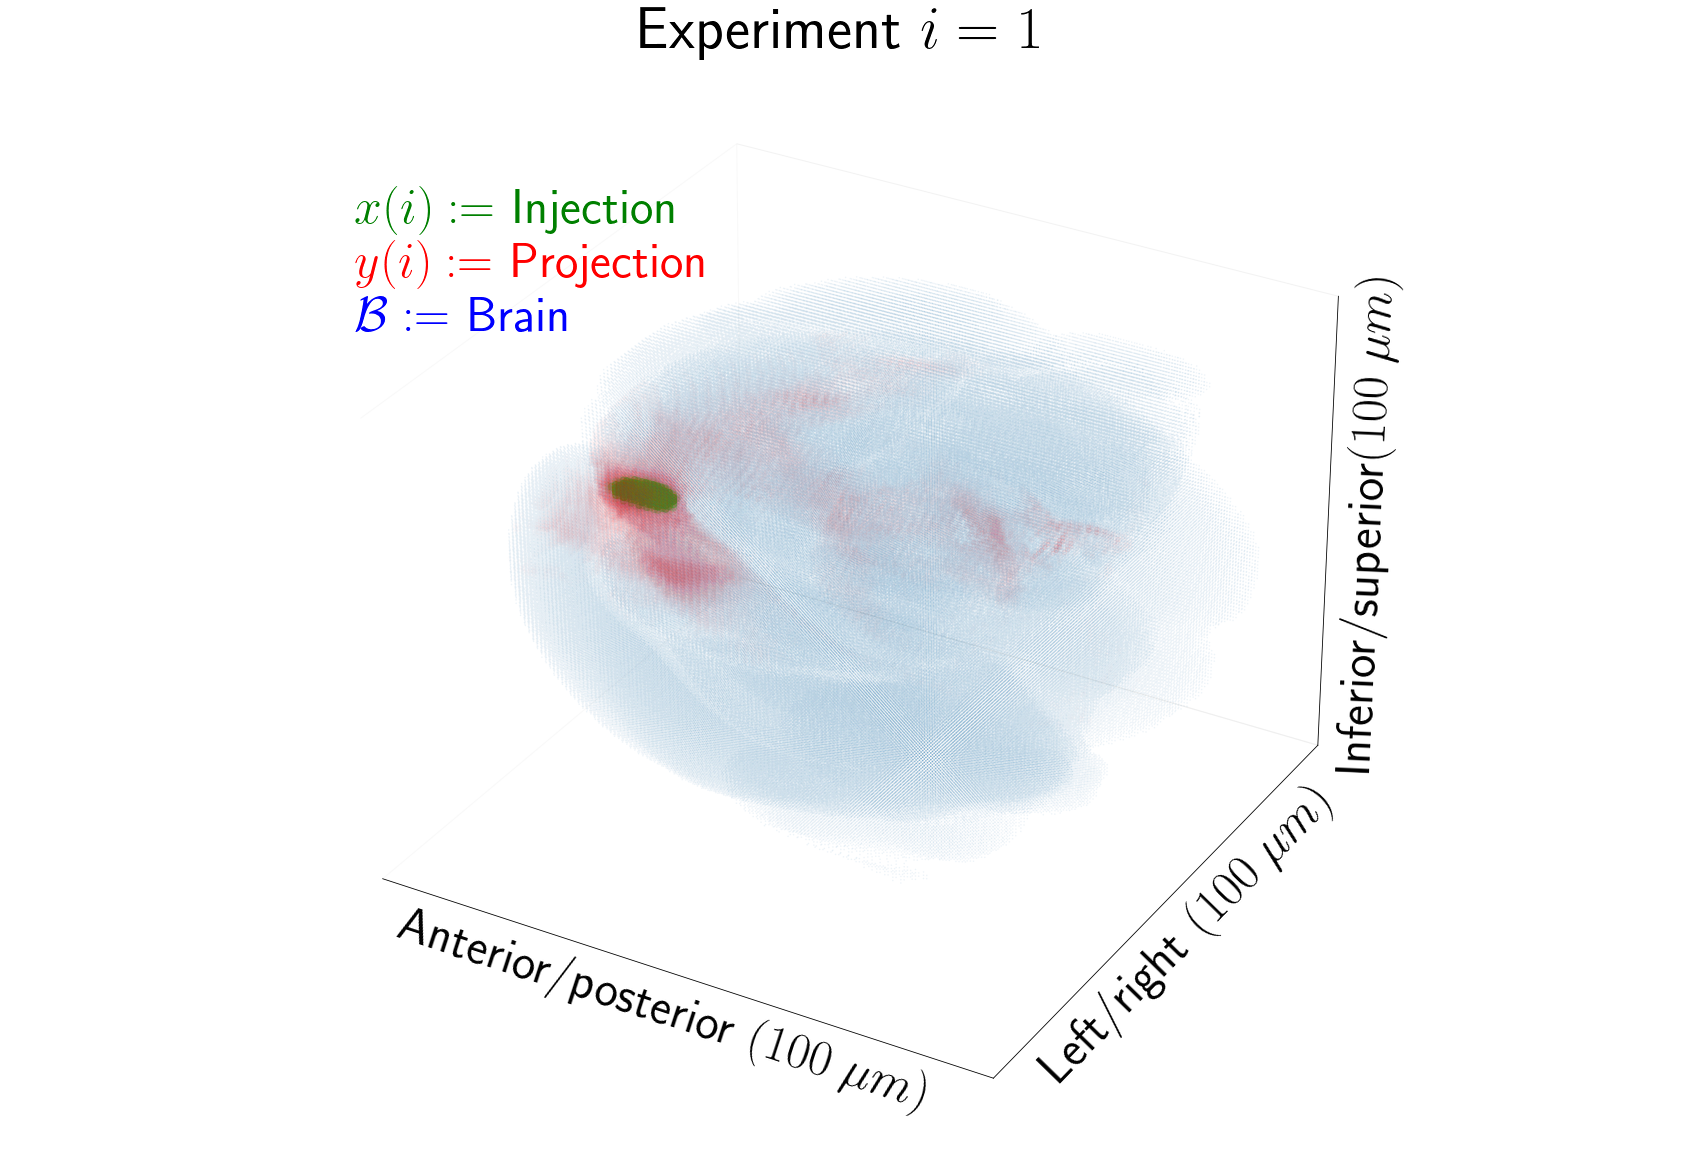

In [6]:
fig, ax = plt.subplots(figsize=(30, 20))
ax.set_axis_off()
#outer = gridspec.GridSpec(2, 3, wspace=0.1, hspace=0.1)

#fig.add_subplot(ax)

#i = 1
#ax = plt.Subplot(fig,  projection='3d')
ax = fig.add_subplot(1,1,1, projection='3d')
sid = 315
nvox = connectivity_data.structure_datas[sid].projections.shape[1]
proj_colors = np.zeros((nvox,4))
proj_colors[:,0] = 1.0
proj_colors[:, 3] = .15* connectivity_data.structure_datas[sid].projections[0] / connectivity_data.structure_datas[sid].projections[0].max()

ax.scatter(connectivity_data.structure_datas[sid].projection_mask.coordinates[:,1], 
           connectivity_data.structure_datas[sid].projection_mask.coordinates[:,2], 
           connectivity_data.structure_datas[sid].projection_mask.coordinates[:,0], s= 20, c= proj_colors)

nvox = connectivity_data.structure_datas[sid].injections.shape[1]
inj_colors = np.zeros((nvox,4))
inj_colors[:,1] = 1.0
inj_colors[:, 3] = connectivity_data.structure_datas[sid].injections[0] / connectivity_data.structure_datas[sid].injections[0].max()


ax.scatter(connectivity_data.structure_datas[sid].projection_mask.coordinates[:,1], 
           connectivity_data.structure_datas[sid].projection_mask.coordinates[:,2], 
           connectivity_data.structure_datas[sid].projection_mask.coordinates[:,0], alpha = .06, s = .4)

ax.scatter(connectivity_data.structure_datas[sid].injection_mask.coordinates[:,1], 
           connectivity_data.structure_datas[sid].injection_mask.coordinates[:,2], 
           connectivity_data.structure_datas[sid].injection_mask.coordinates[:,0], s= 50, c= inj_colors)


ax.set_xlabel('Anterior/posterior ' + r'$(100\; \mu m)$', fontsize = 50)
ax.set_ylabel('Left/right ' + r'$(100 \;\mu m)$', fontsize = 50)
ax.set_zlabel('Inferior/superior' + r'$(100 \;\mu m)$', fontsize = 50)
ax.set_xticklabels(ax.get_xticklabels(),  fontsize = 30)
ax.set_yticklabels(ax.get_yticklabels(),  fontsize = 30)
ax.set_zticklabels(ax.get_zticklabels(),  fontsize = 30)

ax.xaxis.pane.fill = False
ax.yaxis.pane.fill = False
ax.zaxis.pane.fill = False
#ax.view_init(0, 140)
ax.set_facecolor('white')
ax.text2D(0.05, 0.85, r'$x(i) :=$' + " Injection", transform=ax.transAxes, size = 50, c = 'green')
ax.text2D(0.05, 0.8, r'$y(i) :=$' +  " Projection", transform=ax.transAxes, size = 50, c = 'red')
ax.text2D(0.05, 0.75, r'$\mathcal B :=$' + " Brain", transform=ax.transAxes, size = 50, c = 'blue')
ax.set_title('Experiment ' + r'$i = 1$', size = 60)

plt.margins(0,0,0)
plt.gca().xaxis.set_major_locator(plt.NullLocator())
plt.gca().yaxis.set_major_locator(plt.NullLocator())
plt.gca().zaxis.set_major_locator(plt.NullLocator())

plt.savefig(f'{workingdirectory}/paper/KoelleConn_revision/figs/inj_proj_figure_v2')


In [7]:
with open('data/meta/leafs.pickle', 'rb') as handle:
    leafs = pickle.load(handle)
    
#load version 3 list
ontological_order = get_ordered_summary_structures(cache,167587189)
#due to redundancy in ccfv3, remove 'MDRNv', 'MDRNd' from summary structures (include as leafs of MDRN)
ontological_order[277]
ontological_order = np.setdiff1d(ontological_order, [1098, 1107])
#load version 2 list
#ontological_order = get_ordered_summary_structures(cache,687527945)

mcc = MouseConnectivityCache(manifest_file = 'data/metda/mouse_connectivity_manifest.json')
st = mcc.get_structure_tree()
ai_map = st.get_id_acronym_map()
ia_map = {value: key for key, value in ai_map.items()}

#regionalize voxel model: compare with regional model
#regional parameters
cre = None
eid_set=None
high_res=False
threshold_injection = False

COARSE_STRUCTURE_SET_ID = 2
DEFAULT_STRUCTURE_SET_IDS = tuple([COARSE_STRUCTURE_SET_ID])
tree = cache.get_structure_tree()
default_structures = tree.get_structures_by_set_id(DEFAULT_STRUCTURE_SET_IDS)
default_structure_ids = [st['id'] for st in default_structures if st['id'] != 934]

In [8]:
connectivity_data.ai_map = ai_map
connectivity_data.get_summarystructures(data_info)

In [9]:
summary_structures = {}
for sid in major_structure_ids:
    summary_structures[sid] = connectivity_data.structure_datas[sid].summary_structures
connectivity_data.summary_structures = summary_structures#get_indices_2ormore(connectivity_data.leafs)


In [10]:
expd = pd.DataFrame([])
for sid in major_structure_ids:
    nexp = leafs[sid].shape[0]
    #print(nexp)
    for i in range(nexp):
        #print(ia_map[connectivity_data.structure_datas[sid].summary_structures[i]])
        expd = expd.append(pd.DataFrame([ia_map[sid],
                                         ia_map[connectivity_data.structure_datas[sid].summary_structures[i]], 
                                         connectivity_data.creline[sid][i]]).transpose())


In [11]:
isoind = np.where(np.asarray(expd[0]) == 'Isocortex')[0]
expd_iso = expd.iloc[isoind]

In [12]:
plt.rc('text', usetex=False)

/Users/samsonkoelle/miniconda3/envs/mcm_class/lib/python3.7/site-packages/ipykernel_launcher.py:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  
/Users/samsonkoelle/miniconda3/envs/mcm_class/lib/python3.7/site-packages/ipykernel_launcher.py:16: UserWarning: FixedFormatter should only be used together with FixedLocator
  app.launch_new_instance()
/Users/samsonkoelle/miniconda3/envs/mcm_class/lib/python3.7/site-packages/ipykernel_launcher.py:26: UserWarning: FixedFormatter should only be used together with FixedLocator
/Users/samsonkoelle/miniconda3/envs/mcm_class/lib/python3.7/site-packages/ipykernel_launcher.py:36: UserWarning: FixedFormatter should only be used together with FixedLocator


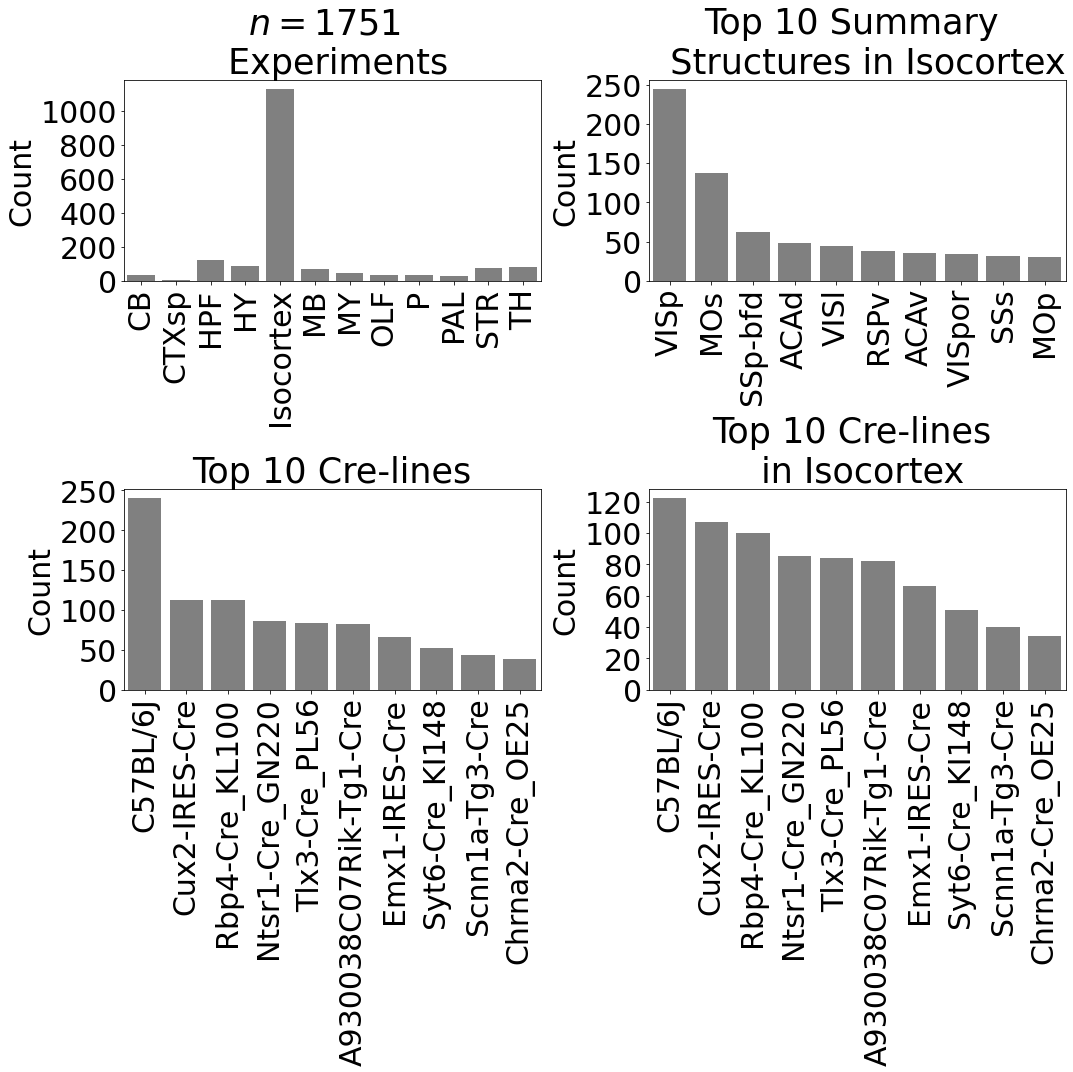

In [15]:

fig, axes = plt.subplots(2,2, figsize = (15,15))

sns.countplot(x=0, color='grey',  data=expd, ax = axes[0,0])
axes[0,0].set_title(r'$n = 1751$ ' + ' \n Experiments', fontsize = 35)
axes[0,0].set_ylabel('Count', fontsize = 30)
plt.draw()
axes[0,0].set_xticklabels(axes[0,0].get_xticklabels(), rotation=90, fontsize = 30)
axes[0,0].set_yticklabels(axes[0,0].get_yticklabels(),fontsize = 30)
axes[0,0].set_xlabel('', fontsize = 30)
axes[0,0].set_facecolor('white')

sns.countplot(x=1,  color='grey',  data=expd_iso, ax = axes[0,1],order=expd_iso[1].value_counts().iloc[:10].index)
axes[0,1].set_title('Top 10 Summary \n  Structures in Isocortex', fontsize = 35)
axes[0,1].set_ylabel('Count', fontsize = 30)
plt.draw()
axes[0,1].set_yticklabels(axes[0,1].get_yticklabels(),fontsize = 30)

axes[0,1].set_xlabel('', fontsize = 30)
axes[0,1].set_xticklabels(axes[0,1].get_xticklabels(), rotation=90, fontsize = 30)
axes[0,1].set_facecolor('white')

sns.countplot(x=2,  color='grey',  data=expd, ax = axes[1,0],order=expd[2].value_counts().iloc[:10].index)
axes[1,0].set_title('Top 10 Cre-lines', fontsize = 35)
axes[1,0].set_ylabel('Count', fontsize = 30)
plt.draw()
axes[1,0].set_yticklabels(axes[1,0].get_yticklabels(),fontsize = 30)

axes[1,0].set_xlabel('', fontsize = 30)
axes[1,0].set_xticklabels(axes[1,0].get_xticklabels(), rotation=90, fontsize = 30)
axes[1,0].set_facecolor('white')

sns.countplot(x=2,color='grey',  data=expd_iso, ax = axes[1,1],order=expd_iso[2].value_counts().iloc[:10].index)
axes[1,1].set_title('Top 10 Cre-lines \n in Isocortex', fontsize = 35)
axes[1,1].set_ylabel('Count', fontsize = 30)
plt.draw()
axes[1,1].set_yticklabels(axes[1,1].get_yticklabels(),fontsize = 30)

axes[1,1].set_xlabel('', fontsize = 30)
axes[1,1].set_xticklabels(axes[1,1].get_xticklabels(), rotation=90, fontsize = 30)
axes[1,1].set_facecolor('white')

plt.tight_layout()
plt.savefig(f'{workingdirectory}/paper/KoelleConn_revision/figs/datasummary')

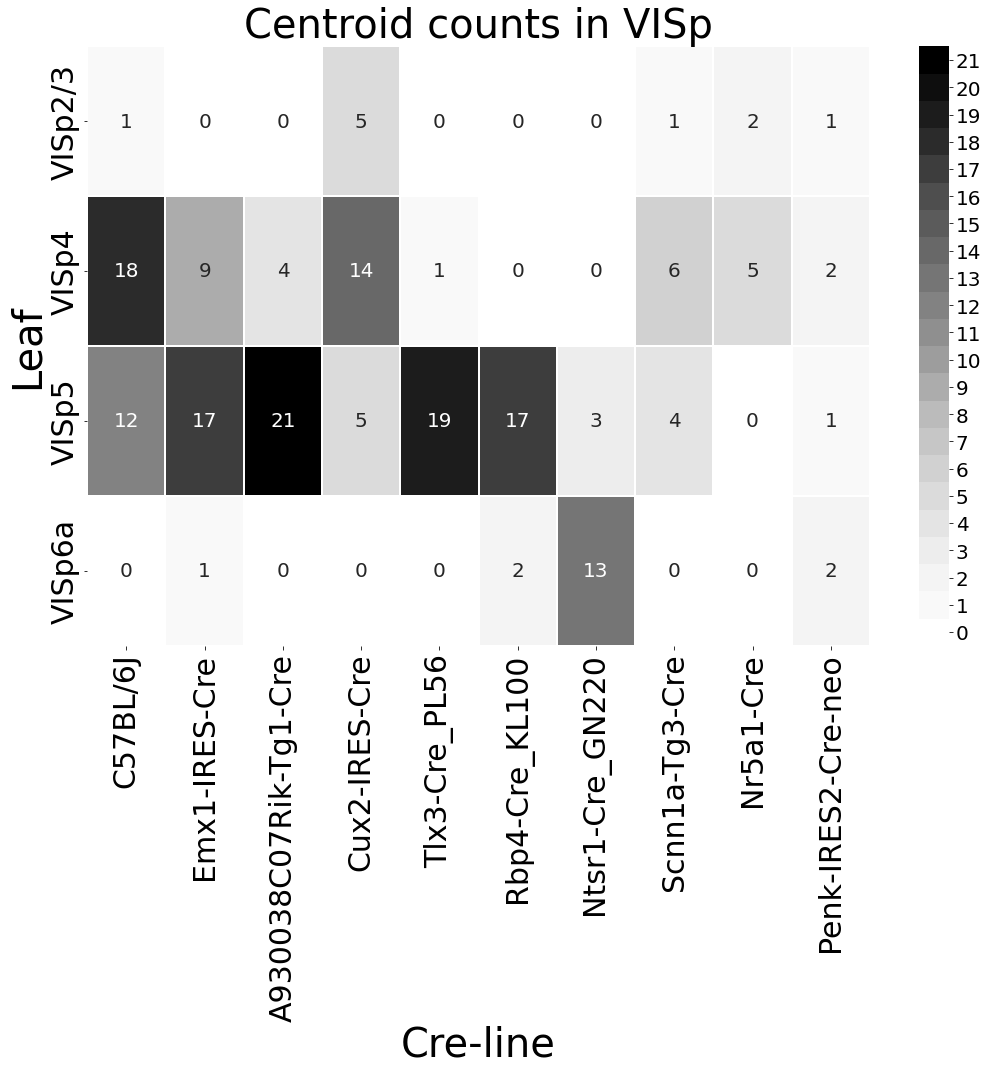

In [16]:
sid = 315
ls = [ia_map[leafs[sid][i]] for i in range(len(leafs[sid]))]
crs = connectivity_data.creline[sid]
df = pd.DataFrame(np.asarray([ls, crs, np.ones(len(ls))]).transpose())
df.columns = np.asarray(['Leaf', 'Creline','present'])
a = df.pivot_table(values='present',index='Leaf',columns='Creline',aggfunc=np.sum)
a = a.fillna(0)
revels = a
ticks=np.arange(revels.values.min(),revels.values.max()+1 )
boundaries = np.arange(revels.values.min()-.5,revels.values.max()+1.5 )
cmap = plt.get_cmap("Greys", revels.values.max()-revels.values.min()+1)
fig, ax = plt.subplots(figsize = (15,15))
tops = np.argsort(-np.sum(revels.loc[np.asarray(['VISp2/3','VISp4' ,'VISp5' ,'VISp6a'  ])], axis = 0))[:10]
rts = revels.loc[np.asarray(['VISp2/3','VISp4' ,'VISp5' ,'VISp6a'  ])].iloc[:,tops]
sns.heatmap(rts, annot=True, linewidths=0.4, cmap=cmap,
        cbar_kws={"ticks":ticks, "boundaries":boundaries}, ax=ax, annot_kws={"fontsize":20})
cbar = ax.collections[0].colorbar
cbar.ax.tick_params(labelsize=20)
ax.set_xlabel('Cre-line' , fontsize = 40)
ax.set_ylabel('Leaf' , fontsize = 40)
ax.set_xticklabels(ax.get_xticklabels(), fontsize = 30)
ax.set_yticklabels(ax.get_yticklabels(), fontsize = 30)
ax.set_title('Centroid counts in VISp', fontsize = 40)
plt.tight_layout()
plt.savefig(f'{workingdirectory}/paper/KoelleConn_revision/figs/visp_counts')

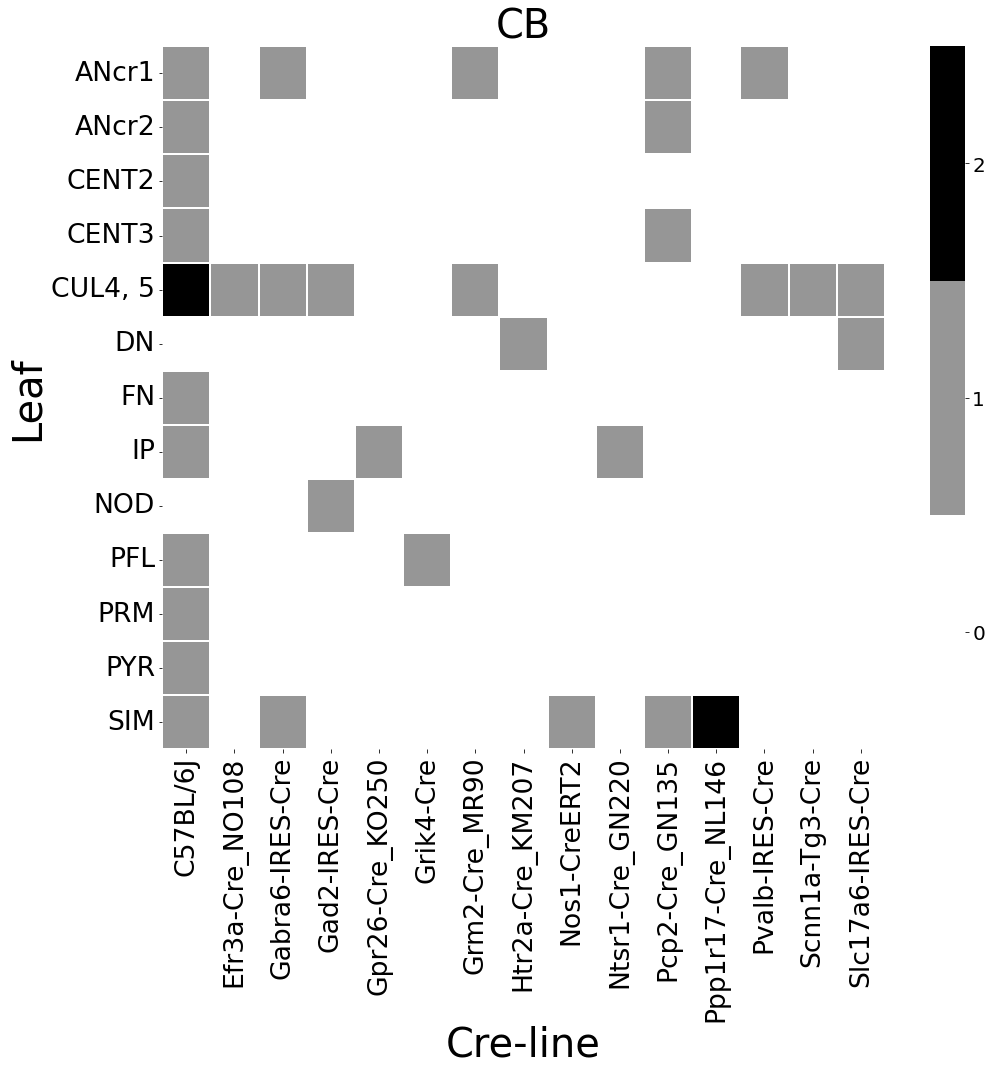

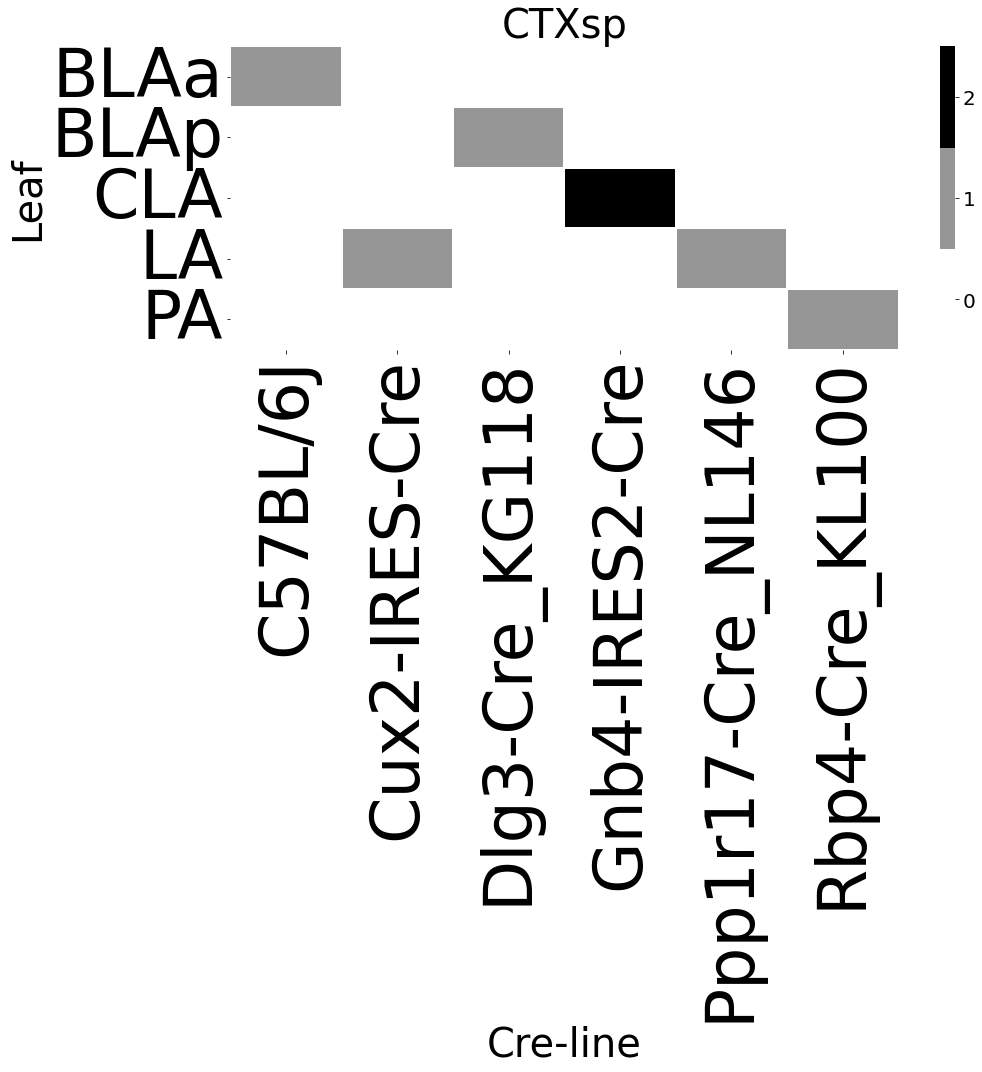

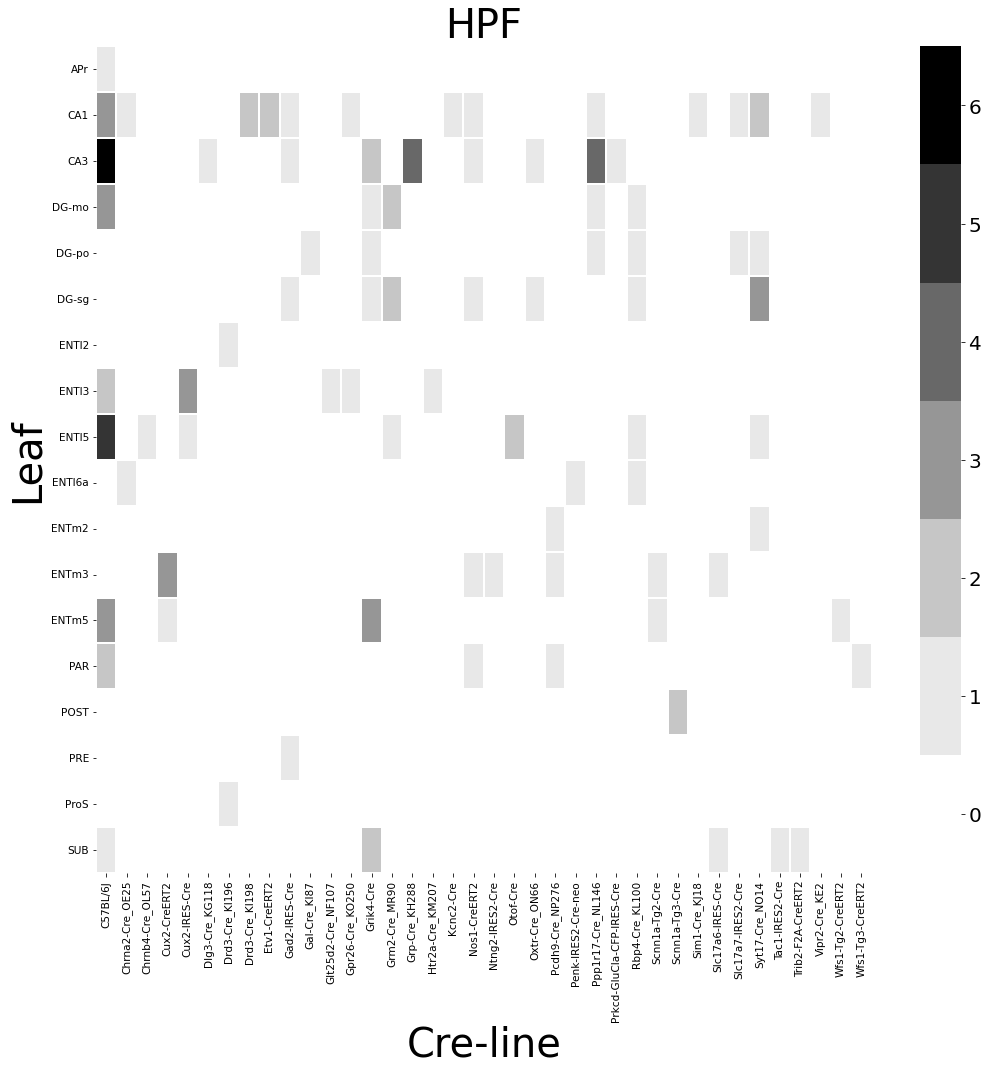

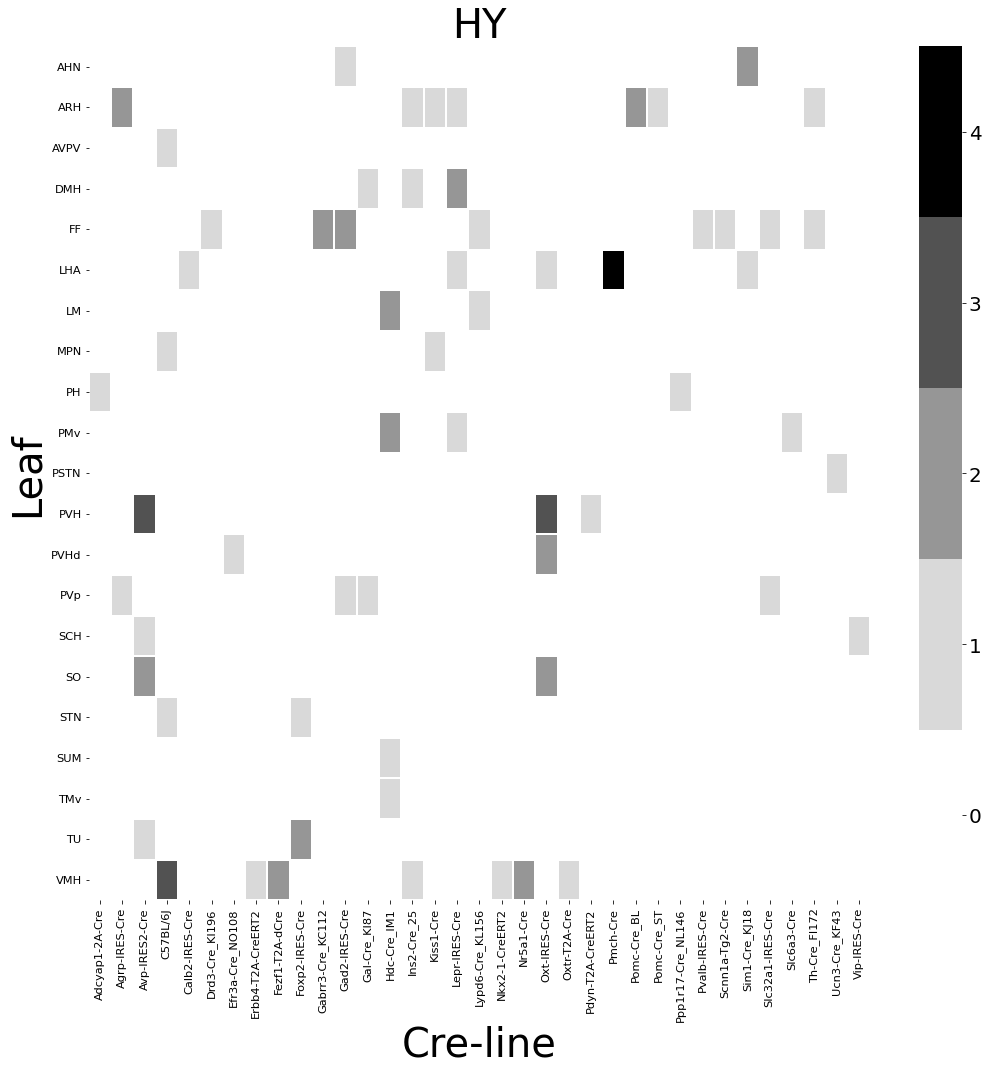

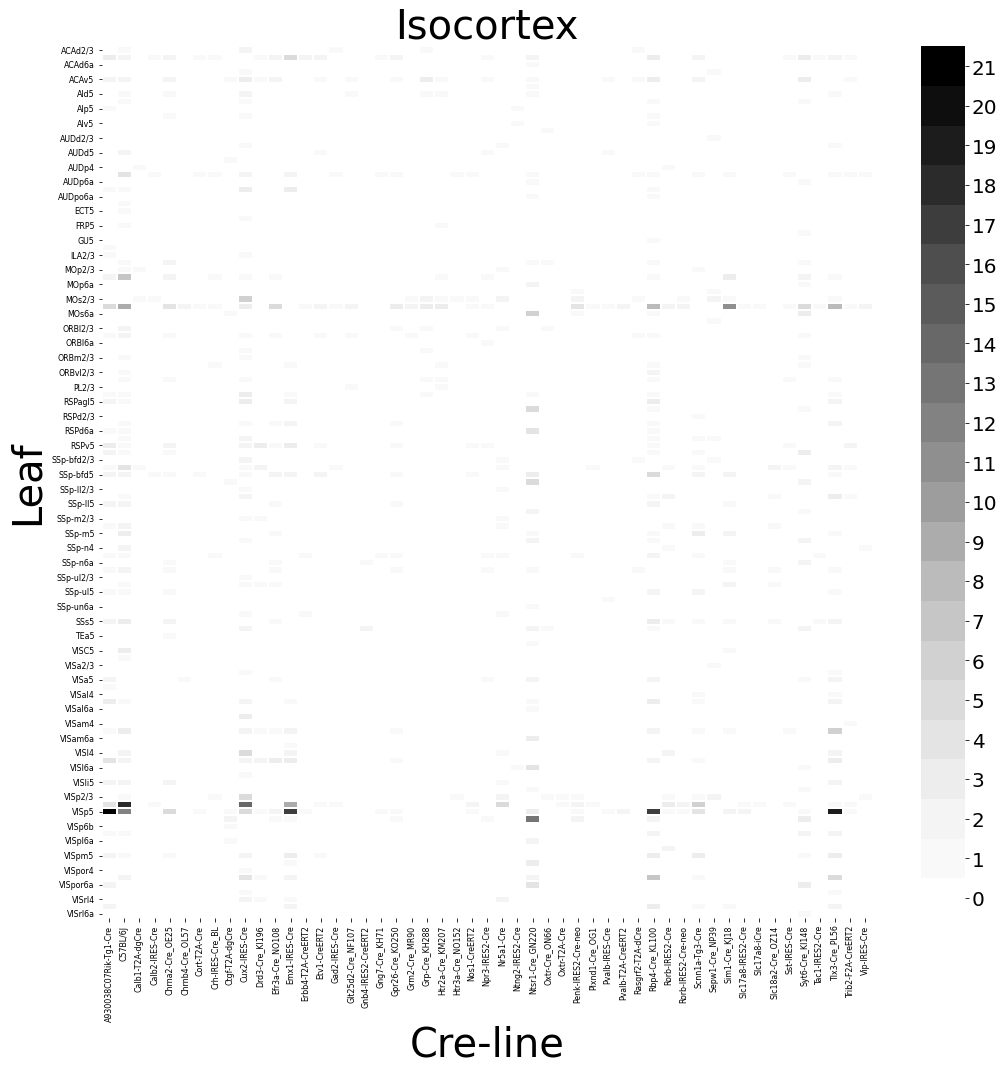

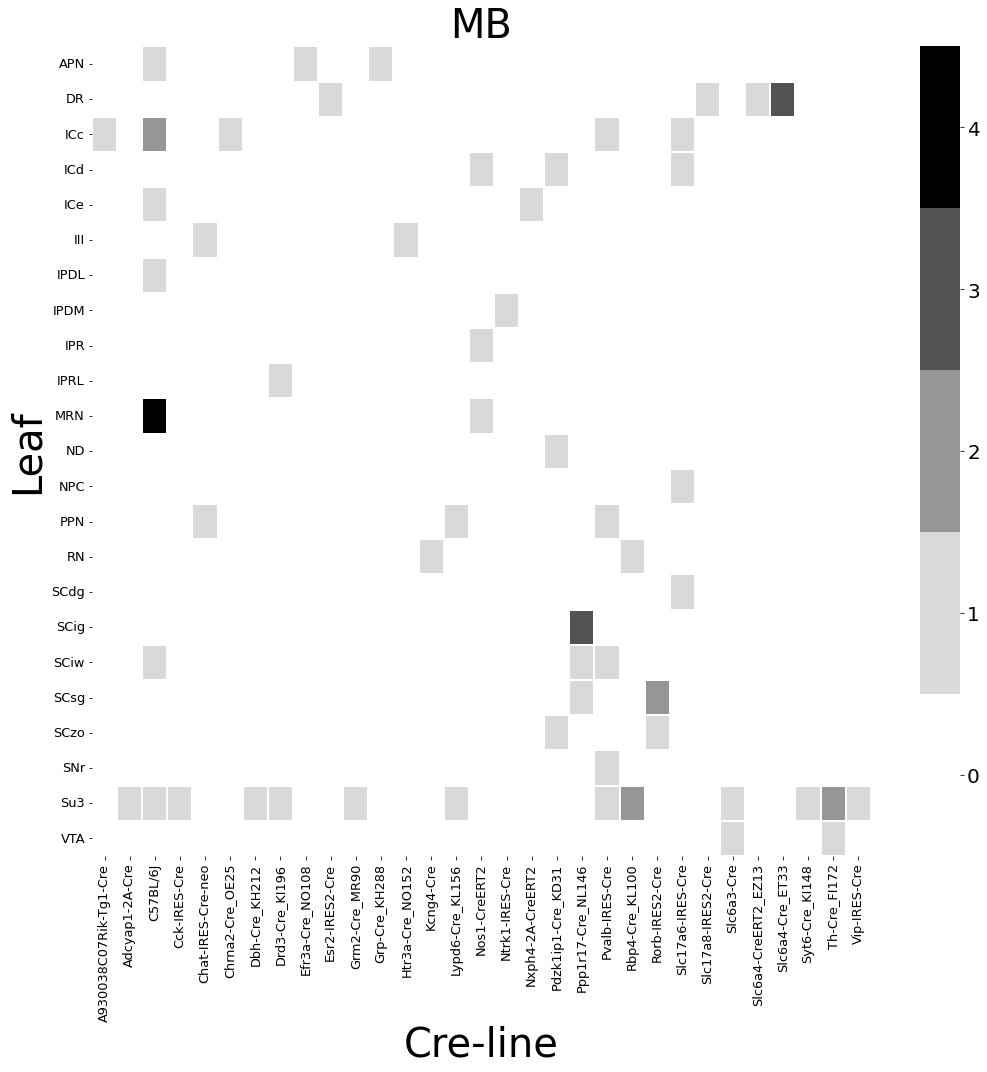

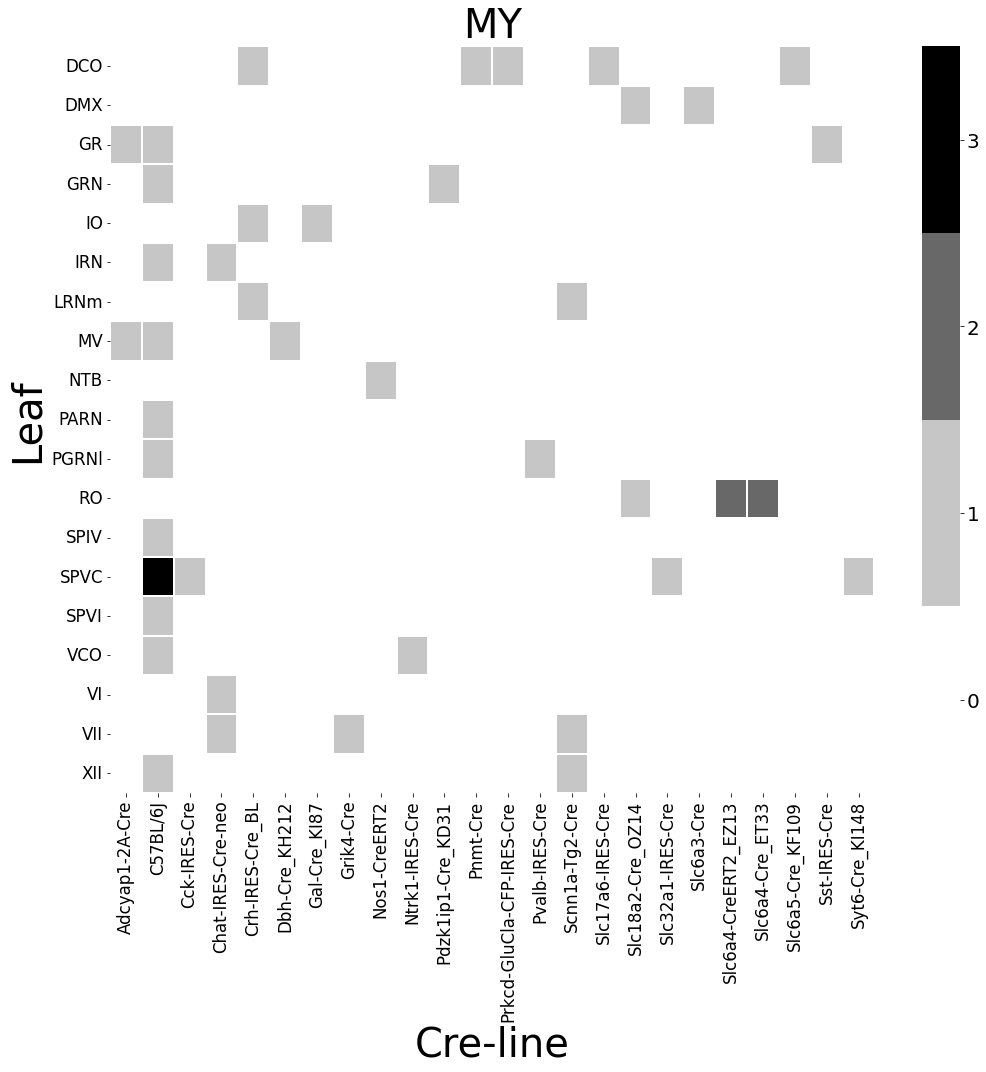

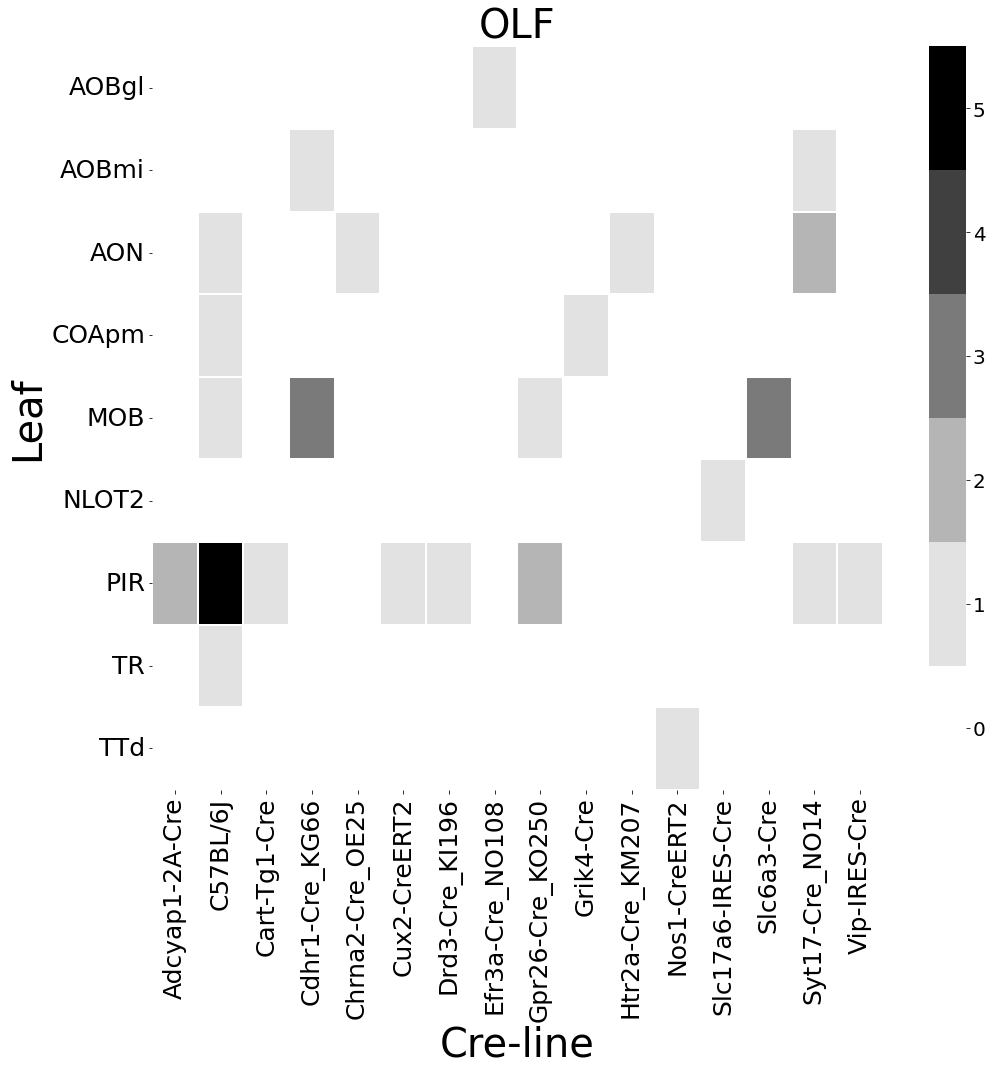

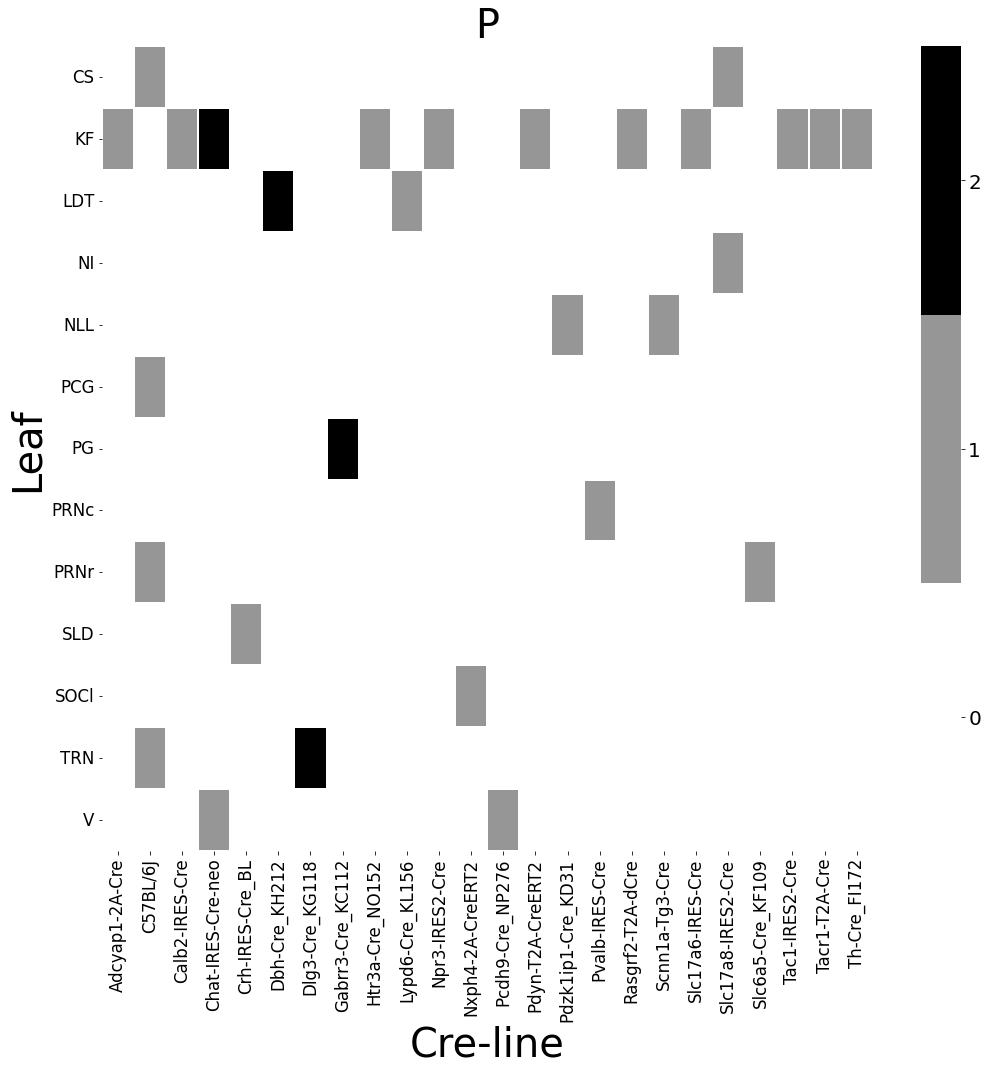

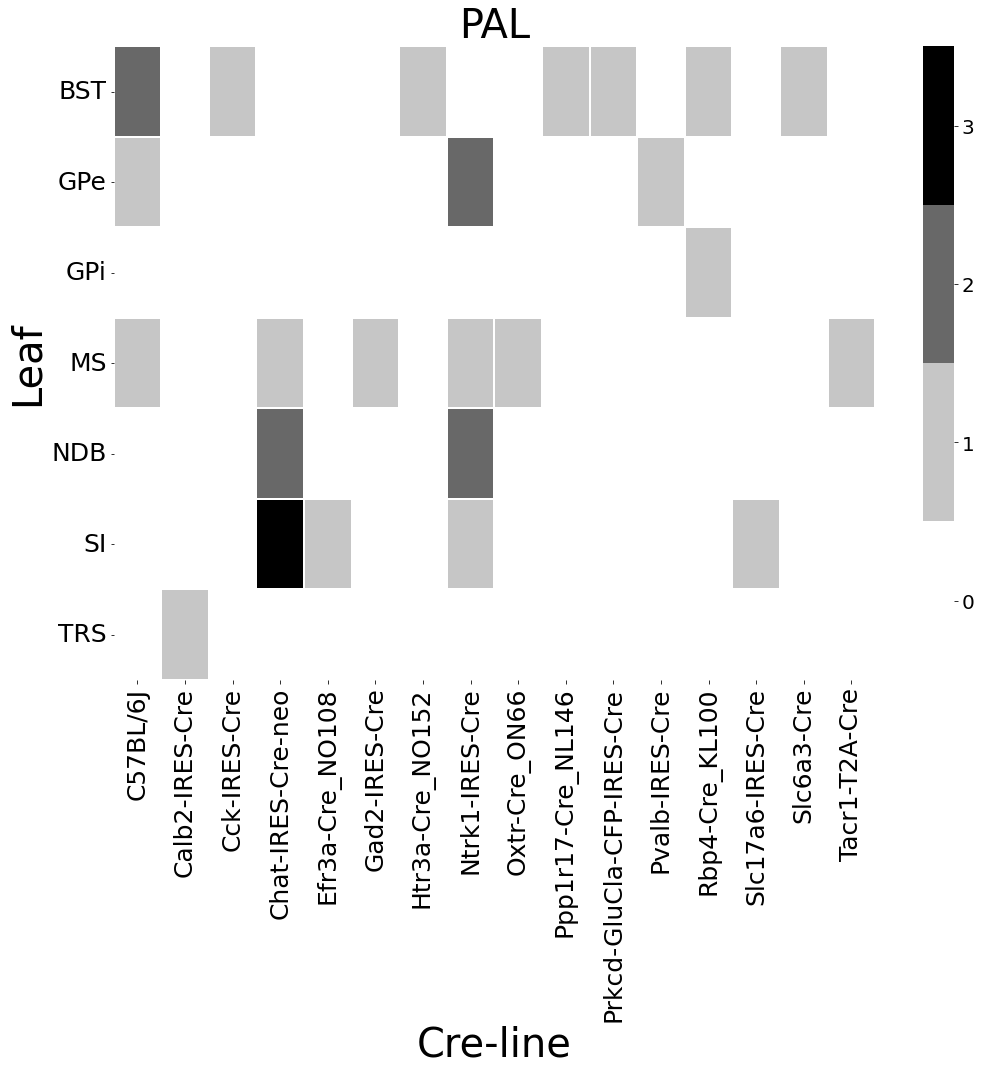

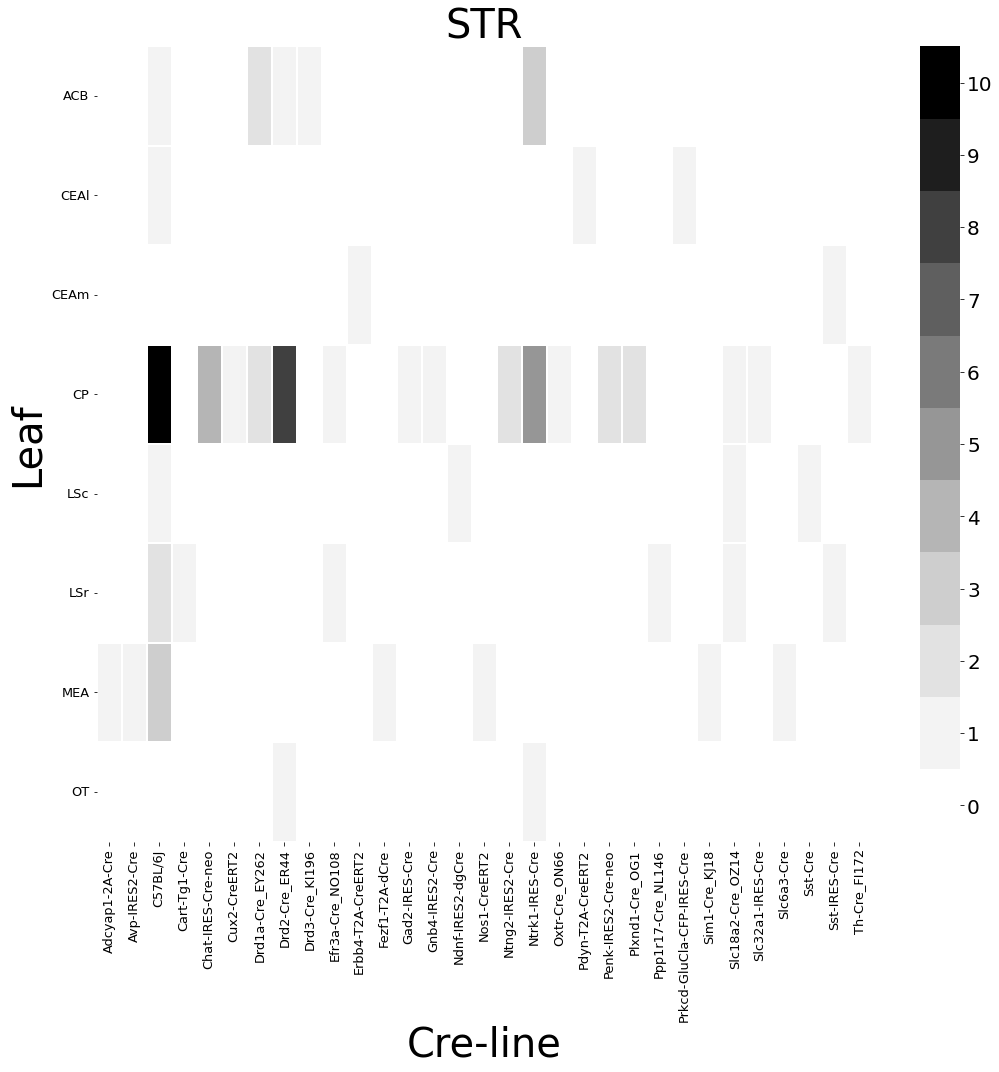

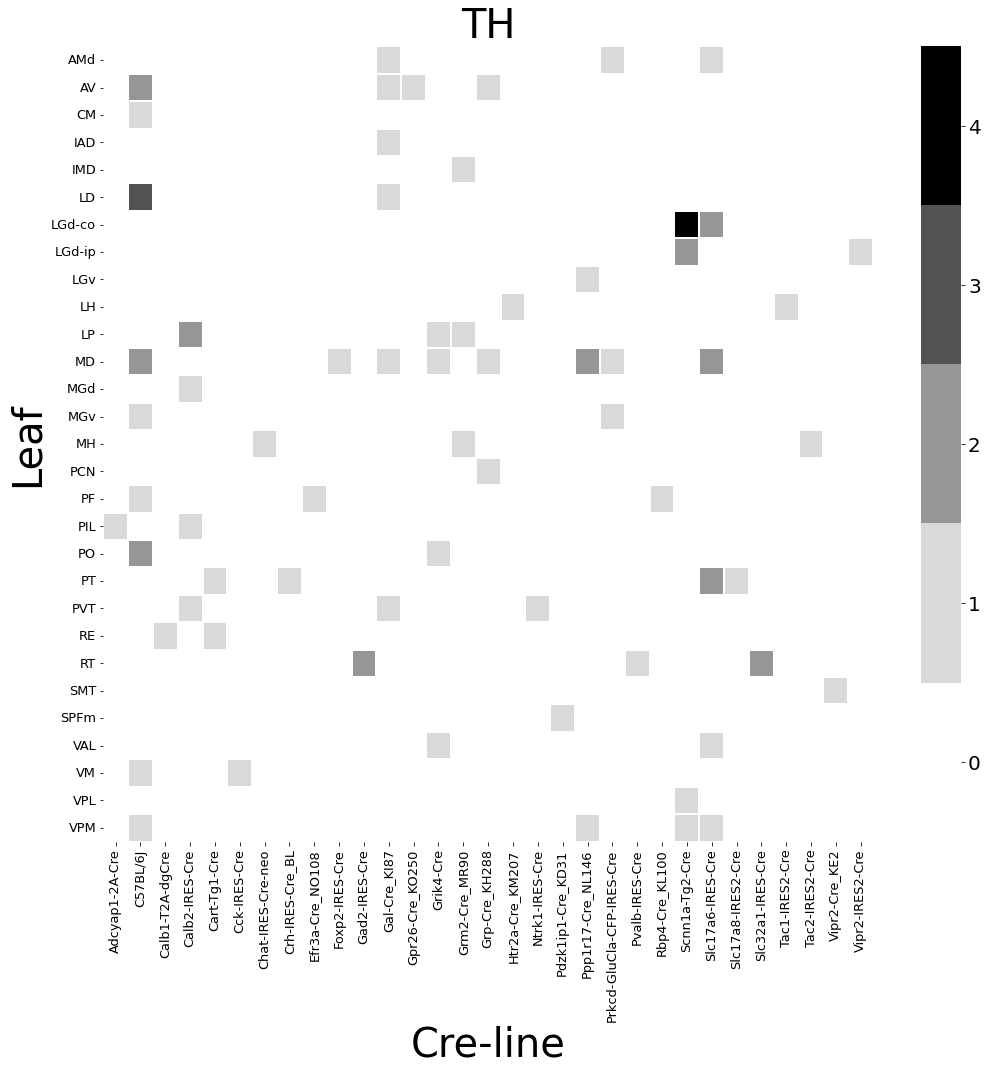

In [17]:
for m in range(len(major_structure_ids)):

    sid = major_structure_ids[m]
    source_mask = Mask.from_cache(cache, structure_ids=[sid], hemisphere_id=2)
    source_key = source_mask.get_key(structure_ids=ontological_order_leaves)
    source_regions, source_counts = nonzero_unique(source_key, return_counts=True)

    nexp = connectivity_data.creline[sid].shape[0]

    ls = [ia_map[leafs[sid][i]] for i in range(len(leafs[sid]))]
    crs = connectivity_data.creline[sid]
    df = pd.DataFrame(np.asarray([ls, crs, np.ones(len(ls))]).transpose())
    df.columns = np.asarray(['Leaf', 'Creline','present'])
    a = df.pivot_table(values='present',index='Leaf',columns='Creline',aggfunc=np.sum)
    a = a.fillna(0)
    revels = a
    ticks=np.arange(revels.values.min(),revels.values.max()+1 )
    boundaries = np.arange(revels.values.min()-.5,revels.values.max()+1.5 )
    cmap = plt.get_cmap("Greys", revels.values.max()-revels.values.min()+1)
    fig, ax = plt.subplots(figsize = (15,15))
    ydim = revels.shape[1]
    xdim = revels.shape[0]
    sns.heatmap(revels, annot=False, linewidths=0.4, cmap=cmap,
            cbar_kws={"ticks":ticks, "boundaries":boundaries}, ax=ax)
    ax.set_title(str(major_structures[m]), fontsize = 40)
    plt.draw()
    ax.set_xticklabels(ax.get_xticklabels(), fontsize = 400 / ydim, rotation = 90)
    
    ax.set_yticklabels(ax.get_yticklabels(), fontsize = 400 / ydim, rotation = 0)
    cbar = ax.collections[0].colorbar
    cbar.ax.tick_params(labelsize=20)
    ax.set_xlabel('Cre-line' , fontsize = 40)
    ax.set_ylabel('Leaf' , fontsize = 40)
    plt.tight_layout()
    fig.savefig(f'{workingdirectory}/paper/KoelleConn_revision/figs/{str(major_structures[m])} centroid density')
